In [51]:
import corpus as corpus_class
import categories, filters, vocabulary_builders
from feature_extractors import multinomial_model, tfidf
from filters import std_filters

import numpy as np
import time

from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

## initializing corpus

In [3]:
qfile_train = 'question_train.csv'
qcatfile_train = 'question_category_train.csv'
catfile = 'category.csv'
qfile_test = 'question_test.csv'

In [4]:
filtees = std_filters()

In [5]:
corpus = corpus_class.corpus( categories.categories() );
corpus.load(qfile_train, qcatfile_train);
corpus.process(**filtees, corpus_size=-1);

### simple split

In [6]:
corpus.simple_split(0.33);
corpus.make_features(-1);

# Standart Avaraging

In [9]:
clf_nb = MultinomialNB(alpha=0.1)
clf_lr = LogisticRegression(C=1.0)

In [ ]:
bcf = VotingClassifier(estimators=[('lr', clf_lr), ('nb', clf_nb)], voting='soft') #('svc', clf_svc)

In [ ]:
bcf.fit(corpus.X_tr, corpus.y_tr);

In [ ]:
bcf.score(corpus.X_te, corpus.y_te)

## SVM

In [57]:
corpus.make_features(2000);
t = time.time()
lsa = TruncatedSVD(n_components=1000)
lsa.fit(corpus.X_tr, corpus.y_tr)
print(time.time() - t)
t = time.time()
clf_lda = LDA(n_components=13)
clf_lda.fit(lsa.transform(corpus.X_tr), corpus.y_tr)
print(time.time() - t)

26.75756812095642
13.772958993911743


In [66]:
clf_lda.score(lsa.transform(corpus.X_te), corpus.y_te)

0.55779739386296767

# Using a Classfier for avaraging

In [ ]:
corpus.cv_split(8)
SEED = corpus.random_seed
SEED

In [ ]:
P = []
lP = []
corpus.reset()
for corpus in corpus:
    corpus.make_features()
    
    clf_nb = MultinomialNB(alpha=0.1)
    clf_nb.fit(corpus.X_tr, corpus.y_tr)
    
    clf_lr = LogisticRegression(C=2.0)
    clf_lr.fit(corpus.X_tr, corpus.y_tr)
    
    #clf_svc = SVC(C=1.0, kernel='linear', probability=True)
    #clf_svc.fit(corpus.X_tr, corpus.y_tr)
    
    CLFS = [clf_nb, clf_lr]
    A = [ clf.predict_proba( corpus.X_te ) for clf in CLFS]
    P += [ np.concatenate(A, axis=1) ]
    lP += [ corpus.y_te ]

split = 6

Xp_tr = np.concatenate(P[:split], axis=0)
yp_tr = np.concatenate(lP[:split], axis=0)

Xp_te = np.concatenate(P[split:], axis=0)
yp_te = np.concatenate(lP[split:], axis=0)

In [ ]:
#clf_fin = LDA()
clf_fin = RandomForestClassifier(n_estimators=100, max_features=6)
#clf_fin = LogisticRegression(C=1.0)
clf_fin.fit(Xp_tr, yp_tr)
clf_fin.score(Xp_te, yp_te)

In [ ]:
print(corpus)

# Correlation

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

In [70]:
clf_nb = MultinomialNB(alpha=0.1)
clf_lr = LogisticRegression(C=1.0)

In [73]:
def corr_plot(y1, y2, corpus=corpus):
    C = np.zeros((14,14))
    for i, j in zip(y1, y2):
        C[i, j] += 1
    
    x = np.repeat(np.arange(14), 14)
    y = np.repeat(np.arange(14).reshape(1,14), 14, axis=0)
    plt.figure(figsize=(8, 6))
    
    lables = corpus.cats[:]
    plt.yticks(np.arange(14), lables, rotation=0, ha='right')

    plt.scatter(x, y, s=C.flatten())

In [71]:
clf_nb.fit(corpus.X_tr, corpus.y_tr)
clf_lr.fit(corpus.X_tr, corpus.y_tr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

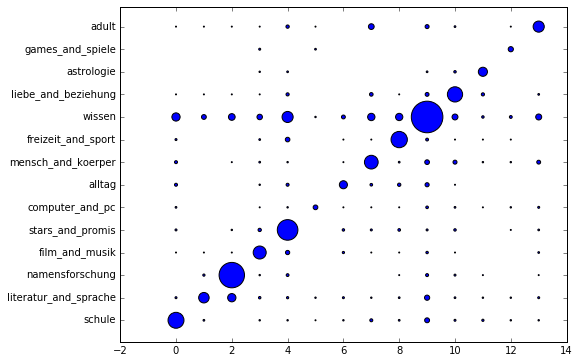

In [74]:
y1 = clf_nb.predict(corpus.X_te)
y2 = clf_lda.predict(lsa.transform(corpus.X_te))
corr_plot(y1, y2)

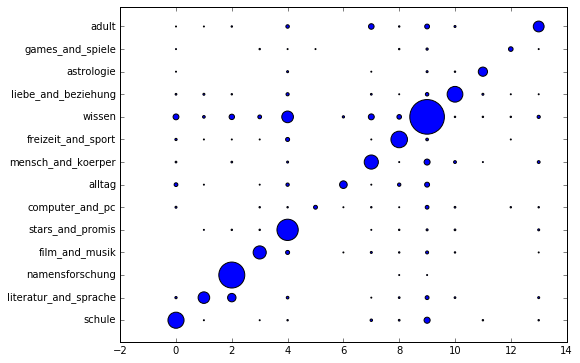

In [75]:
y1 = clf_nb.predict(corpus.X_te)
y1 = clf_lr.predict(corpus.X_te)
corr_plot(y1, y2)

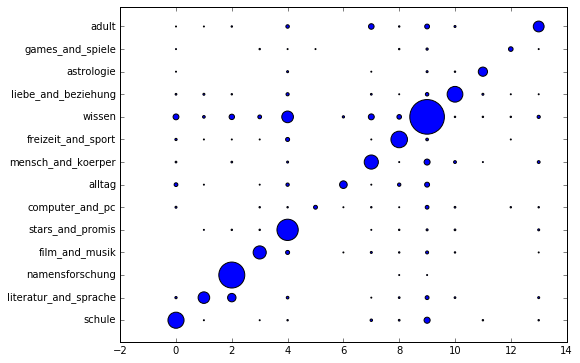

In [76]:
y1 = clf_lr.predict(corpus.X_te)
y2 = clf_lda.predict(lsa.transform(corpus.X_te))
corr_plot(y1, y2)